In [4]:
pip install Theano

  Created wheel for Theano: filename=Theano-1.0.5-cp37-none-any.whl size=2668112 sha256=fdc57b09d586139b7d58b25db2227f255541e00fdc48400cd0f72f79283b60a2
  Stored in directory: C:\Users\n10648771\AppData\Local\pip\Cache\wheels\89\40\74\3a0b7d937890c66c4373120117ebf4ba99f4889b4a0a6a810c
Successfully built Theano
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install pymc3

Note: you may need to restart the kernel to use updated packages.


# JUST A TEST!!!
# Bayesian Inference with a help of an American Friend

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import pymc3 as pm
import theano.tensor as tt
import theano
import datetime
import time
import warnings

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\ProgramData\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


#### My data from CSSE

In [7]:
confirmed=pd.read_csv(r'confirmed_global.csv')
death=pd.read_csv(r'deaths_global.csv')

In [8]:
confirmed.head(5)
confirmed.index

RangeIndex(start=0, stop=266, step=1)

In [9]:
confirmed.drop(['Province/State','Lat','Long'],axis=1,inplace=True)

In [10]:
death.drop(['Province/State','Lat','Long'],axis=1,inplace=True)

In [11]:
data_end   = '9/30/20' #Take the data until yesterday
data_begin = '1/22/20'
num_days_to_predict = 40


In [12]:

z=confirmed.loc[confirmed['Country/Region'] == 'Australia']

In [13]:
m=z.groupby(['Country/Region']).sum()

In [14]:
m.reset_index(level=0, inplace=True)

m.loc[:,data_begin:data_end]

KeyError: "None of ['index'] are in the columns"

In [16]:
data_end   = '4/9/20' #Take the data until yesterday
data_begin = '3/20/20'
num_days_to_predict = 28


In [17]:
cases_obs=np.array(m.loc[:,data_begin:data_end])[0]

In [18]:
len(cases_obs)

21

In [19]:
with pm.Model() as model:
    # true cases at begin of loaded data but we do not know the real number
    I_begin = pm.Lognormal("I_begin", mu=np.log(cases_obs[0]), sigma=0.9)

In [20]:
date_data_end = confirmed.loc[confirmed["Country/Region"] == "Australia", data_begin:data_end].columns[-1]
month, day, year = map(int,date_data_end.split('/'))
date_data_end = datetime.date(year+2000, month, day)
date_today = date_data_end + datetime.timedelta(days=1)
print('Cases yesterday ({}): {} and day before yesterday: {}'.format(date_data_end.isoformat(), *cases_obs[:-3:-1]))
num_days = len(cases_obs)
np.random.seed(0)

Cases yesterday (2020-04-09): 6108 and day before yesterday: 6010


In [21]:
def SIR_model(spread_rate, rec_rate, S_begin, I_begin, N):
    new_I_0 = tt.zeros_like(I_begin)
    def next_day(spread_rate, S_t, I_t, _):
        new_I_t = spread_rate/N*I_t*S_t
        S_t = S_t - new_I_t
        I_t = I_t + new_I_t - rec_rate * I_t
        return S_t, I_t, new_I_t
    outputs , _  = theano.scan(fn=next_day, sequences=[spread_rate], 
                               outputs_info=[S_begin, I_begin, new_I_0])
    S_all, I_all, new_I_all = outputs
    return S_all, I_all, new_I_all

In [22]:
with pm.Model() as model:
    # true cases at begin of loaded data but we do not know the real number
    I_begin = pm.Lognormal("I_begin", mu=np.log(cases_obs[0]), sigma=0.9)

    # fraction of people that are newly infected each day
    Spread_rate = pm.Lognormal("Spread_rate", mu=np.log(0.4), sigma=0.5)

    # fraction of people that recover each day, recovery rate mu
    rec_rate = pm.Lognormal('rec_rate', mu=np.log(1/8), sigma=0.2)

    # prior of the error of observed cases
    σ_obs = pm.HalfCauchy("σ_obs", beta=1)

    N_au = 83.7e6

    # -------------------------------------------------------------------------- #
    # training the model with loaded data
    # -------------------------------------------------------------------------- #

    S_begin = N_au - I_begin
    S_past, I_past, new_I_past = SIR_model(Spread_rate=Spread_rate * tt.ones(num_days-1), rec_rate=rec_rate, 
                                               S_begin=S_begin, I_begin=I_begin,
                                               N=N_au)
    new_infections_obs = np.diff(cases_obs)

    # Approximates Poisson
    # calculate the likelihood of the model:
    # observed cases are distributed following studentT around the model

    pm.StudentT(
        "obs",
        nu=4,
        mu=new_I_past,
        sigma=new_I_past ** 0.5 * σ_obs,
        observed=new_infections_obs
        )  
    
    S_past = pm.Deterministic('S_past', S_past)
    I_past = pm.Deterministic('I_past', I_past)
    new_I_past = pm.Deterministic('new_I_past', new_I_past)

    # -------------------------------------------------------------------------- #
    # prediction, start with no changes in policy
    # -------------------------------------------------------------------------- #
    
    # delay in days between contracting the disease and being recorded
    delay = pm.Lognormal("delay", mu=np.log(8), sigma=0.1)

    S_begin = S_past[-1]
    I_begin = I_past[-1]
    forecast_no_change = SIR_model(Spread_rate=Spread_rate*tt.ones(num_days_to_predict), rec_rate=rec_rate, 
                        S_begin=S_begin, I_begin=I_begin, N=N_au)
    S_no_change, I_no_change, new_I_no_change = forecast_no_change

    #saves the variables for later retrieval
    pm.Deterministic('S_no_change', S_no_change)
    pm.Deterministic('I_no_change', I_no_change)
    pm.Deterministic('new_I_no_change', new_I_no_change)

    # -------------------------------------------------------------------------- #
    # social distancing, m reduced by about 50 percent
    # -------------------------------------------------------------------------- #
    #For all following predictions:
    length_transient = 7  # days


    # Spread_rate is decreased by 50%
    reduc_factor_mild = 0.5
    days_offset = 0  # start the decrease in spreading rate after this

    time_arr = np.arange(num_days_to_predict)

    # change in m along time
    Spread_rate_correction = tt.clip((time_arr - delay - days_offset + 1) / length_transient, 0, 1)
    Spread_rate_t_soc_dist= Spread_rate * (1 - Spread_rate_correction * reduc_factor_mild) 

    S_begin = S_past[-1]
    I_begin = I_past[-1]
    forecast_soc_dist = SIR_model(Spread_rate=Spread_rate_t_soc_dist, rec_rate=rec_rate, 
                        S_begin=S_begin, I_begin=I_begin, 
                        N=N_au)
    S_soc_dist, I_soc_dist, new_I_soc_dist = forecast_soc_dist
    pm.Deterministic('S_soc_dist', S_soc_dist)
    pm.Deterministic('I_soc_dist', I_soc_dist)
    pm.Deterministic('new_I_soc_dist', new_I_soc_dist)

    # -------------------------------------------------------------------------- #
    # isolation, almost no new infections besides baseline after transient phase
    # -------------------------------------------------------------------------- #

    # Spread_rate is decreased by 90%
    reduc_factor_strong = 0.9
    days_offset = 0  # start the decrease in spreading rate after this

    # spreading of people who transmit although they are isolated
    time_arr = np.arange(num_days_to_predict)

    # change in Spread_rate along time
    Spread_rate_correction = tt.clip((time_arr - delay - days_offset+1) / length_transient, 0, 1)
    Spread_rate_t_isol= Spread_rate * (1 - Spread_rate_correction * reduc_factor_strong)

    S_begin = S_past[-1]
    I_begin = I_past[-1]
    forecast_isol = SIR_model(Spread_rate=Spread_rate_t_isol , rec_rate=rec_rate, 
                              S_begin=S_begin, I_begin=I_begin, 
                              N=N_au)
    S_isol, I_isol, new_I_isol = forecast_isol

    pm.Deterministic('S_isol', S_isol)
    pm.Deterministic('I_isol', I_isol)  
    pm.Deterministic('new_I_isol', new_I_isol)

    # -------------------------------------------------------------------------- #
    # isolation 5 days later, almost no new infections besides baseline after transient phase
    # -------------------------------------------------------------------------- #

    # Spread_rate is decreased by 90%
    reduc_factor_strong = 0.9
    days_offset = 5  # start the decrease in spreading rate after this

    # spreading of people who transmit although they are isolated
    time_arr = np.arange(num_days_to_predict)

    # change in Spread_rate along time
    Spread_rate_correction = tt.clip((time_arr - delay - days_offset+1) / length_transient, 0, 1)
    Spread_rate_t_isol_later= Spread_rate * (1 - Spread_rate_correction * reduc_factor_strong) 

    S_begin = S_past[-1]
    I_S_beginbegin = I_past[-1]
    forecast_isol_later = SIR_model(Spread_rate=Spread_rate_t_isol_later, rec_rate=rec_rate, 
                         S_begin=S_begin, I_begin=I_begin, 
                         N=N_au)
    S_isol_later, I_isol_later, new_I_isol_later = forecast_isol_later

    pm.Deterministic('S_isol_later', S_isol_later)
    pm.Deterministic('I_isol_later', I_isol_later)  
    pm.Deterministic('new_I_isol_later', new_I_isol_later)


    # -------------------------------------------------------------------------- #
    # isolation 7 days earlyier, almost no new infections besides baseline after transient phase
    # -------------------------------------------------------------------------- #

    # Spread_rate is decreased by 90%
    reduc_factor_strong = 0.9
    days_offset = -5  # start the decrease in spreading rate after this

    # spreading of people who transmit although they are isolated
    time_arr = np.arange(num_days_to_predict)

    # change in Spread_rate along time
    Spread_rate_correction = tt.clip((time_arr - delay - days_offset+1) / length_transient, 0, 1)
    Spread_rate_t_isol_earlyier= Spread_rate * (1 - Spread_rate_correction * reduc_factor_strong) 

    S_begin = S_past[-1]
    I_S_begin = I_past[-1]
    forecast_isol_earlyier = SIR_model(Spread_rate=Spread_rate_t_isol_earlyier, rec_rate=rec_rate, 
                         S_begin=S_begin, I_begin=I_begin, 
                         N=N_au)
    S_isol_earlyier, I_isol_earlyier, new_I_isol_earlyier = forecast_isol_earlyier

    pm.Deterministic('S_isol_earlyier', S_isol_earlyier)
    pm.Deterministic('I_isol_earlyier', I_isol_earlyier)  
    pm.Deterministic('new_I_isol_earlyier', new_I_isol_earlyier)

    # -------------------------------------------------------------------------- #
    # run model, pm trains and predicts when calling this
    # -------------------------------------------------------------------------- #

    time_beg = time.time()
    trace = pm.sample(draws=500, tune=800, chains=2)
    print("Model run in {:.2f} s".format(time.time() - time_beg))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [delay, σ_obs, μ, λ, I_begin]


Sampling 2 chains for 800 tune and 500 draw iterations (1_600 + 1_000 draws total) took 292 seconds.
The number of effective samples is smaller than 25% for some parameters.


Model run in 302.65 s


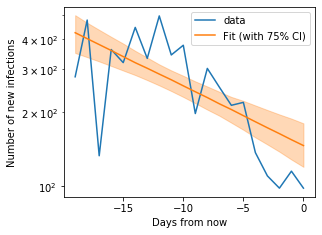

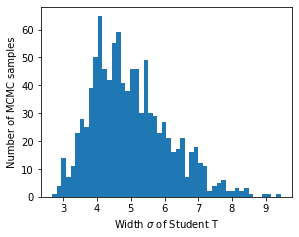

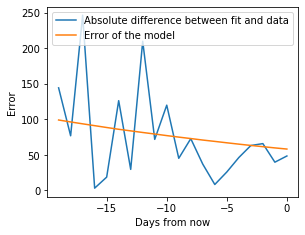

In [23]:

time = np.arange(-len(cases_obs)+2, 1)
plt.figure(figsize=(4.5,3.5))
plt.plot(time, np.diff(cases_obs), label='data')
percentiles = np.percentile(trace.new_I_past, q=12.5, axis=0), np.percentile(trace.new_I_past, q=87.5, axis=0)
plt.plot(time, np.median(trace.new_I_past, axis=0),color='tab:orange', label='Fit (with 75% CI)')
#print(percentiles)
plt.fill_between(time, percentiles[0], percentiles[1], alpha=0.3, color='tab:orange')
plt.yscale('log')
plt.ylabel('Number of new infections')
plt.xlabel('Days from now')
plt.legend()

#print(trace.new_I_past[-1])
#print(trace.new_I_isol[-1])
#print(trace.new_I_no_chan  ge[-1])
plt.figure(figsize=(4.5,3.5))
plt.hist(trace.σ_obs, bins=50)
plt.ylabel('Number of MCMC samples')
plt.xlabel('Width $\sigma$ of Student T')

plt.figure(figsize=(4.5,3.5))
plt.plot(time, np.abs(np.median(trace.new_I_past, axis=0) - np.diff(cases_obs)),
         label='Absolute difference between fit and data')
plt.plot(time, np.sqrt(np.median(trace.new_I_past, axis=0))*np.median(trace.σ_obs, axis=0),
         label='Error of the model')
plt.ylabel('Error')
plt.xlabel('Days from now')
plt.legend(loc='upper left')

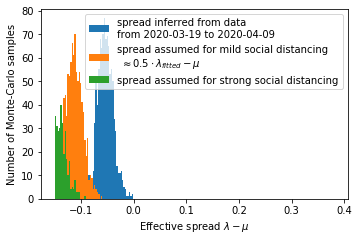

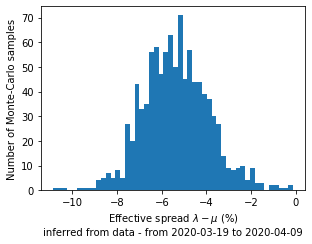

In [24]:
import matplotlib

day_begin = date_data_end - datetime.timedelta(days = num_days)

plt.figure(figsize=(5.5,3.5))
bins = np.linspace(-0.15, 0.38, 200)
plt.hist(trace.λ - trace.μ, bins=bins, 
         label='spread inferred from data\nfrom {} to {}'.format(day_begin.isoformat(), date_data_end.isoformat()))
plt.hist(np.maximum(trace.λ*(1-reduc_factor_mild) ,0) - trace.μ, bins=bins,
         label='spread assumed for mild social distancing\n $\\approx 0.5 \\cdot \\lambda_{fitted} - \mu $')
plt.hist(np.maximum(trace.λ*(1-reduc_factor_strong),0) - trace.μ, bins=bins, 
         label='spread assumed for strong social distancing')
plt.xlabel('Effective spread $\lambda - \mu$')
plt.ylabel('Number of Monte-Carlo samples')
plt.legend()
plt.savefig('Distributions_of_m.png', dpi=200)

plt.figure(figsize=(4.5,3.5))
#bins = np.linspace(-0.11, 0.304, 200)
plt.hist((trace.λ - trace.μ)*100, bins=50)
plt.xlabel('Effective spread $\lambda - \mu$ (%)\ninferred from data - from {} to {}'.format(day_begin.isoformat(), date_data_end.isoformat()))
plt.ylabel('Number of Monte-Carlo samples')
plt.tight_layout()
plt.savefig('Distributions_of_fitted_m.png', dpi=200)

In [1]:
legends_lang = {
   
    "english": [
        # bottom left
        "confirmed cases",
        [
            "uncontrolled spreading",
            "mild social distancing",
            "strong social distancing",
            "strong social distancing\nstarting at day -5",
        ],
        "Days since intervention",
        "Total confirmed cases in Ausse",
        "Start of intervention",
        # bottom right
        'confirmed cases',['strong social distancing:',
                           '  starting at day 0', 
                           '  starting at day 5',
                           "  starting at day -5"],
        'Days since intervention',
        'Total confirmed cases in Aussie',
        'Start of intervention',
    ],
}
obs_cases_labels = ['new_I_no_change', 'new_I_soc_dist', 
                    'new_I_isol', 'new_I_isol_later', 'new_I_isol_earlyier']

date_today_formatted = '{}/{}/{}'.format(date_today.month, date_today.day, str(date_today.year)[2:4])
cases_obs_to_plot = np.array(confirmed.loc[confirmed['Country/Region'] == 'Aussie', '3/9/20':date_today_formatted])[0]
cases_obs_to_plot_future = np.array(confirmed.loc[confirmed['Country/Region'] == 'Aussie', date_today_formatted:])[0]


def return_obs_cases_future(trace):
  obs_cases_future = dict()
  for label in obs_cases_labels:
    obs_cases_future[label] = np.cumsum(trace[label], axis=1) + \
        np.sum(trace.new_I_past, axis=1)[:, None] + trace.I_begin[:, None]
    obs_cases_future[label] = obs_cases_future[label].T
  return obs_cases_future

obs_cases_labels_local = obs_cases_labels[:]
obs_cases_labels_local.pop(3)

for lang, legends_list in legends_lang.items():
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[9, 3.6])

    # bottom left
    colors = ["tab:red", "tab:orange", "tab:green", "gray"]
    dict_obsc_cases = return_obs_cases_future(trace)
    ax = axes[0]

    time = np.arange(-len(cases_obs_to_plot)+1, 1)
    ax.plot(time, cases_obs_to_plot, label=legends_list[0], linewidth=3, color='tab:blue', 
                zorder=5)
    time = np.arange(0, len(cases_obs_to_plot_future))
    ax.plot(time, cases_obs_to_plot_future, '.', markersize=5, color='tab:blue', 
            zorder=5)


    for label, color, legend in zip(obs_cases_labels_local, colors, legends_list[1]):
        time = np.arange(0, num_days_to_predict)
        cases = dict_obsc_cases[label]
        #cases = np.concatenate([np.ones((1,cases.shape[1]))*cases_obs[-1], cases], axis=0)

        median = np.median(cases, axis=-1)
        percentiles = (
            np.percentile(cases, q=2.5, axis=-1),
            np.percentile(cases, q=97.5, axis=-1),
        )
        ax.plot(time, median, color, linewidth=3, label=legend)
        ax.fill_between(time, percentiles[0], percentiles[1], alpha=0.08, color=color)

    ax.set_xlim(-14, 21)
    ax.set_ylim(0, 400_000)
    ax.set_yscale("linear")
    ax.set_xlabel(legends_list[2])
    ax.set_ylabel(legends_list[3])
    # ax.locator_params(axis='y', nbins=4)
    ax.legend(loc="upper left")
    ax.set_xticks([-14, -7, 0, 7, 14, 21])
    ax.locator_params(nbins=4, axis="y")
    func_format = lambda num, _: "${:,.0f}$".format(num).replace(",", "\,")
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(func_format))
    ax.text(-0.29, 0.98, "A", transform=ax.transAxes, size=20)

    ax.annotate(
        legends_list[4],
        xy=(0.0, 20_000),
        xycoords="data",
        xytext=(0.35, 0.4),
        textcoords="axes fraction",
        size=14,
        va="center",
        ha="center",
        arrowprops=dict(
            arrowstyle="simple", connectionstyle="arc3,rad=-0.2", fc="black"
        ),
    )

    ax.annotate(
        "",
        xy=(-5.0, 15_000),
        xycoords="data",
        xytext=(0.32, 0.35),
        textcoords="axes fraction",
        size=14,
        va="center",
        ha="center",
        arrowprops=dict(
            arrowstyle="simple", connectionstyle="arc3,rad=-0.2", fc=colors[3]
        ),
    )

    # bottom right

    f_alone, ax_alone = plt.subplots(figsize=(4.7,3.4))
    for i, (ax, f) in enumerate(((axes[1],fig), (ax_alone, f_alone))):
        colors = ["tab:green", "fuchsia", 'gray']
        time = np.arange(-len(cases_obs_to_plot)+1, 1)
        ax.plot(time, cases_obs_to_plot, label=legends_list[5], linewidth=3, color='tab:blue', 
                    zorder=5)
        time = np.arange(0, len(cases_obs_to_plot_future))
        ax.plot(time, cases_obs_to_plot_future, '.', markersize=5, color='tab:blue', 
                zorder=5)
        time = np.arange(-len(cases_obs) + 1, 1)

        dict_obsc_cases = return_obs_cases_future(trace)
        ax.plot([], [], alpha=0, label=legends_list[6][0])
        for label, color, legend in zip(obs_cases_labels[2:], colors, legends_list[6][1:]):
            time = np.arange(num_days_to_predict)
            cases = dict_obsc_cases[label]
            #cases = np.concatenate(
            #    [np.ones((1, cases.shape[1])) * cases_obs[-1], cases], axis=0
            #)
            median = np.median(cases, axis=-1)
            percentiles = (
                np.percentile(cases, q=2.5, axis=-1),
                np.percentile(cases, q=97.5, axis=-1),
            )
            ax.plot(time, median, color, linewidth=3, label=legend)
            ax.fill_between(time, percentiles[0], percentiles[1], alpha=0.08, color=color)

        ax.set_xlim(-14, 21)
        ax.set_ylim(0, 400_000)
        ax.set_yscale("linear")
        ax.set_xlabel(legends_list[7])
        ax.set_ylabel(legends_list[8])
        ax.locator_params(axis="y", nbins=4)
        ax.legend(loc="upper left")
        ax.set_xticks([-14, -7, 0, 7, 14, 21])
        func_format = lambda num, _: "${:,.0f}$".format(num).replace(",", "\,")
        ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(func_format))

        ax.annotate(
            legends_list[9],
            xy=(0.0, 20_000),
            xycoords="data",
            xytext=(0.35, 0.4),
            textcoords="axes fraction",
            size=14,
            va="center",
            ha="center",
            arrowprops=dict(
                arrowstyle="simple", connectionstyle="arc3,rad=-0.15", fc=colors[0]
            ),
        )
        ax.annotate(
            "",
            xy=(5.0, 40_000),
            xycoords="data",
            xytext=(0.4, 0.35),
            textcoords="axes fraction",
            size=14,
            va="center",
            ha="center",
            arrowprops=dict(
                arrowstyle="simple", connectionstyle="arc3,rad=-0.2", fc=colors[1]
            ),
        )

        ax.annotate(
            "",
            xy=(-5.0, 15_000),
            xycoords="data",
            xytext=(0.32, 0.35),
            textcoords="axes fraction",
            size=14,
            va="center",
            ha="center",
            arrowprops=dict(
                arrowstyle="simple", connectionstyle="arc3,rad=-0.2", fc=colors[2]
            ),
        )
        if i == 0:
            axes[1].text(-0.29, 0.98, "B", transform=ax.transAxes, size=20)

        f.tight_layout()


    # wrapping up
    fig.savefig(
        path_to_save + "cumulative_corona_aus_combined_{}.png".format(lang), dpi=300
    )
    #f_alone.tight_layout()
    f_alone.savefig(
        path_to_save + "cumulative_corona_aus_right_{}.png".format(lang), dpi=300
    )

print('effective m: {:.3f} +- {:.3f}'.format(1+np.median(trace.λ - trace.μ), np.std(trace.λ - trace.μ)))

NameError: name 'date_today' is not defined

In [25]:
confirmed = confirmed[confirmed['Country/Region'] =='Australia']
new_row = confirmed.loc[:,'1/22/20':].sum(axis=0)
confirmed= confirmed.append(new_row, ignore_index=True)
confirmed['Country/Region'].fillna('Aussie', inplace=True)
confirmed=confirmed[confirmed['Country/Region']!='Australia']

In [26]:
confirmed

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,9/21/20,9/22/20,9/23/20,9/24/20,9/25/20,9/26/20,9/27/20,9/28/20,9/29/20,9/30/20
8,Aussie,0.0,0.0,0.0,0.0,4.0,5.0,5.0,6.0,9.0,...,26942.0,26972.0,26980.0,27000.0,27016.0,27040.0,27044.0,27055.0,27078.0,27096.0


In [29]:
path_to_save=''